# Time Series Analysis and Forecasting of Carbon Dioxide Emission from Various Electric Power Sectors and Countries

This report conducts time series analysis including time series decomposition and forecasting on two CO2 emission datasets, concerning different electric power sectors and different countries. The findings reveal that the coal electric sector has been the primary contributor to CO2 emission between 1973 and 2016. Seasonal variations are observed across all sectors, indicating periodic fluctuations in emissions. Additionally, certain sectors exhibit notable similarities in their emission patterns. Furthermore, the report investigates the historical contributions to global CO2 emissions and identifies the United Kingdom as the sole contributor until around 1880. From 1751 to 2017, all countries display a consistent upward trend in emissions, without any notable seasonality or cycles. Using SARIMA and ARIMA models for forecasting, this report predicts a gradual decrease in CO2 emissions from the total electric power sectors in the future. However, despite this anticipated decline in the electric power sector, global CO2 emissions are still likely to rapidly increase, calling for global effort in reducing CO2 pollution.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from datetime import timedelta
from statsmodels.tsa.seasonal import STL as stl
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
df1 = pd.read_csv("CO2_Emission.csv")
df2 = pd.read_csv("emission data.csv")

## Dataset 1 – Electric Power Sectors

Dataset one contains CO2 emission volume in the world across 8 different electric power sectors and their total from January 1973 to July 2016, recorded each month. The unit is in Million Metric Tons (Mmt) of Carbon Dioxide. This dataset is a multivariate, nonlinear and continuous time series dataset.  
The 9 categories are displayed below.

In [ ]:
df1["Description"].unique()

### Preprocessing

To better understand the dataset, it is divided into 2 datasets, one including monthly emission, another including yearly emission.  
The null values, in other words where ‘Value’ shows ‘Not Available’, are dropped. The ‘Value’ column is then converted into numerical value. The ‘YYYYMM’ column is converted to date data type and used as the new index.

#### Get monthly data

In [3]:
# avoid shallow copyina
df1_month=pd.read_csv("CO2_Emission.csv")
df1_month['YYYYMM']=pd.to_datetime(df1_month['YYYYMM'],format="%Y%m",errors='coerce')
# get index for all rows containing year totals (ie.the null values) for later use
null_index=df1_month[df1_month['YYYYMM'].isnull()].index
# drop year total rows, and convert the rest to date data type
df1_month.dropna(subset=['YYYYMM'], inplace=True)
df1_month['YYYYMM']=pd.to_datetime(df1_month['YYYYMM'],format='%Y%m')
#set month as index
indexMonth=df1_month.set_index(['YYYYMM'])

#### Get yearly data

In [4]:
# take all year totals (where month is 13)
df1_year=df1.iloc[null_index]
# get first 4 digits
df1_year['YYYYMM']=df1_year['YYYYMM'].astype(str).str.slice(0,4)
# convert to datetime
df1_year['YYYYMM']=pd.to_datetime(df1_year['YYYYMM'])
#set year as index
indexYear=df1_year.set_index(['YYYYMM'])

C:\Users\Chuyu\AppData\Local\Temp\ipykernel_18380\408521045.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_year['YYYYMM']=df1_year['YYYYMM'].astype(str).str.slice(0,4)
C:\Users\Chuyu\AppData\Local\Temp\ipykernel_18380\408521045.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_year['YYYYMM']=pd.to_datetime(df1_year['YYYYMM'])


#### Remove null

In [5]:
indexMonth.loc[indexMonth['Value']=='Not Available']
indexMonth = indexMonth[indexMonth['Value'] != 'Not Available']

indexYear.loc[indexYear['Value']=='Not Available']
indexYear = indexYear[indexYear['Value'] != 'Not Available']

#### Convert Value column to numerical

In [6]:
indexMonth['Value']=pd.to_numeric(indexMonth["Value"])
indexYear['Value']=pd.to_numeric(indexYear["Value"])

### Variable of Interest

The variable of interest in this dataset is ‘Value’, referring to carbon dioxide emission volume in Mmt. 

#### Overview

In [7]:
# calculate sum of each sector
grouped_value = indexYear.groupby('Column_Order')['Value'].sum()
# remove the total (last row)
grouped_value=grouped_value.drop(grouped_value.index[-1])

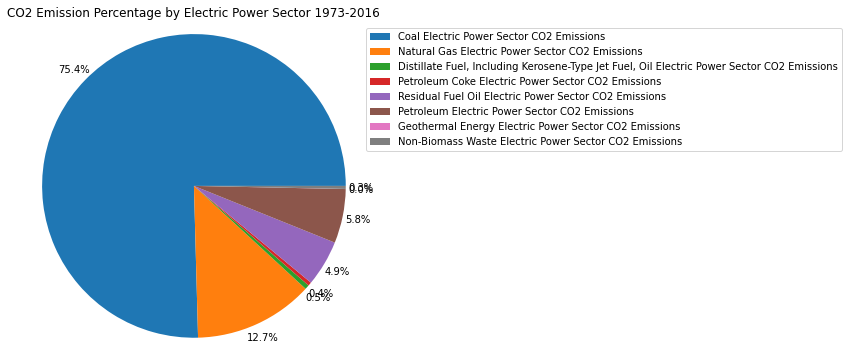

In [8]:
plt.figure(figsize=(6, 6))
plt.pie(grouped_value, labels=None, autopct='%1.1f%%',pctdistance=1.1, labeldistance=1.2)
plt.axis('equal')
plt.ylabel('')
plt.title('CO2 Emission Percentage by Electric Power Sector 1973-2016')
plt.legend(indexYear['Description'].unique(),bbox_to_anchor=(1,1))
plt.show()

This pie chart shows the proportion of CO2 emission from each energy sector from 1973 to 2016. As shown, the Coal Electric Power Sector is responsible for 75.4% of total CO2 emission, with Natural Gas, Petroleum and Residual Fuel Oil Electric Power Sectors following behind with 12.7%, 5.8% and 4.9% respectively.

#### Monthly emission

A pie chart shows the proportion of each sector, however a line graph will reveal insight into temporal trends and changes. Below shows monthly CO2 emission of the 8 sectors and their total from January 1973 to July 2016.

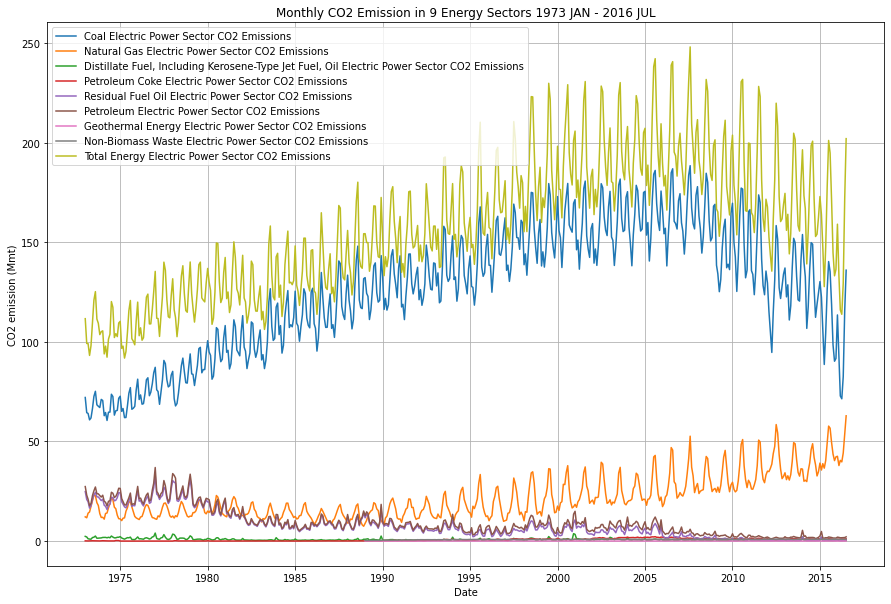

In [9]:
plt.figure(figsize=(15,10))
for i in range(9):
    plt.plot(indexMonth.loc[indexMonth['Column_Order']==i+1,'Value'],label=indexMonth['Description'].unique()[i])
plt.xlabel('Date')
plt.ylabel('CO2 emission (Mmt)')
plt.title('Monthly CO2 Emission in 9 Energy Sectors 1973 JAN - 2016 JUL')
plt.legend()
plt.grid(True)
plt.show()

From the figure, Coal Electric Power Sector has more CO2 emission than all other sectors by a landslide. As a result, the trajectory of Total Energy Electric Power Sector CO2 emission is greatly influenced by that of Coal sector. In terms of time series components, they have quadratic trends and strong seasonality; however, there is no obvious repeating cycles.

#### Monthly emission log

To gain a closer look at low CO2 emission electric power sectors, the y-axis is adjusted logarithmically in the below figures.

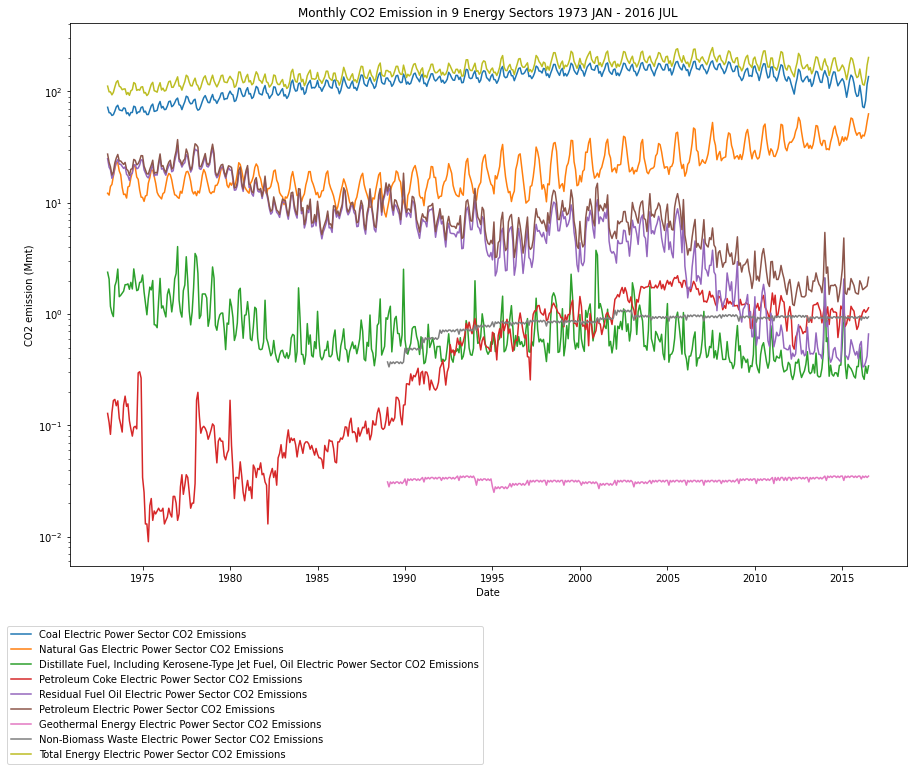

In [10]:
plt.figure(figsize=(15,10))
for i in range(9):
    plt.plot(indexMonth.loc[indexMonth['Column_Order']==i+1,'Value'],label=indexMonth['Description'].unique()[i])
plt.yscale('log')
plt.xlabel('Date')
plt.ylabel('CO2 emission (Mmt)')
plt.title('Monthly CO2 Emission in 9 Energy Sectors 1973 JAN - 2016 JUL')
plt.legend(bbox_to_anchor=(0.5,-0.1))
plt.show()

#### Yearly emission log

The yearly CO2 emission graph provides a more smoothed view.

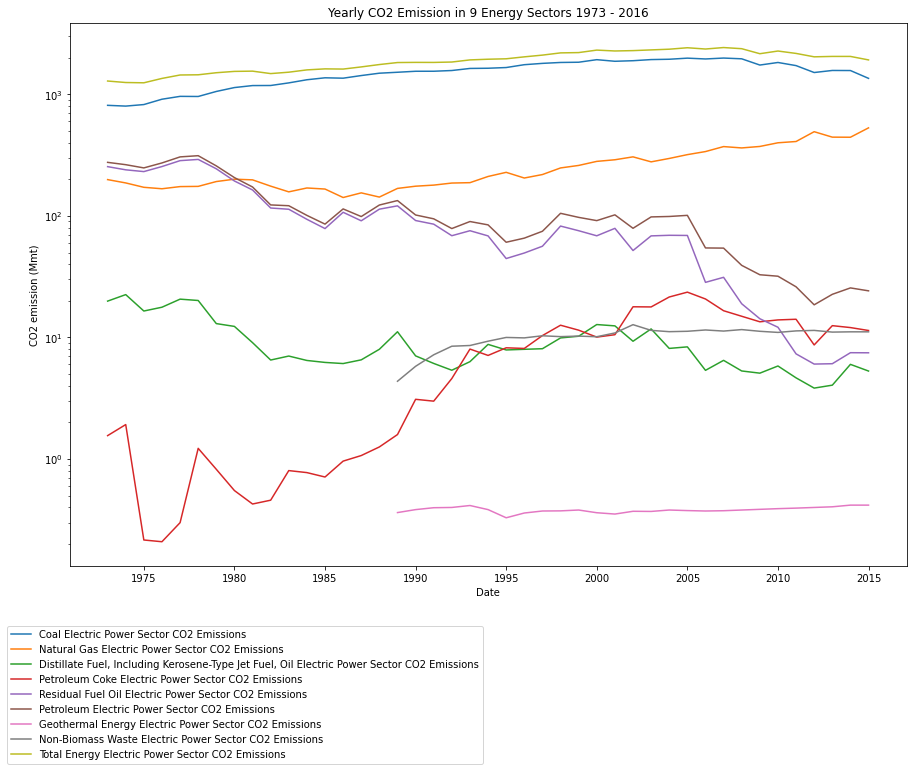

In [11]:
plt.figure(figsize=(15,10))
for i in range(9):
    plt.plot(indexYear.loc[indexYear['Column_Order']==i+1,'Value'],label=indexYear["Description"].unique()[i])
plt.yscale('log')
plt.xlabel('Date')
plt.ylabel('CO2 emission (Mmt)')
plt.title('Yearly CO2 Emission in 9 Energy Sectors 1973 - 2016')
plt.legend(bbox_to_anchor=(0.5,-0.1))
plt.show()

It can be observed that some lines are similar to each other. The orange and green lines have roughly linear trend and they are Natural Gas and Distillate Fuel electric power sectors. The brown and purple lines that follow each other closely with slightly increasing discrepancy in-between are Residual Fuel Oil and Petroleum electric power sectors. The grey and pink lines that share the trend of mirroring horizontal lines are Non-Biomass Waste and Geothermal Energy. The red Petroleum Coke line has more irregularities at the beginning. Overall, they possess trends and seasonality but no cycles. All 9 sectors appear to be non-stationary, requiring decomposition.

### Decomposition

In this section, Coal electric power sector is used as an example because of its impact on total emission. Result of same decomposition analysis conducted on other sectors can be found in the appendix.

#### Coal seasonality

Firstly, the first three years of Coal electric power sector CO2 emission are visualized to spot potential seasonality.

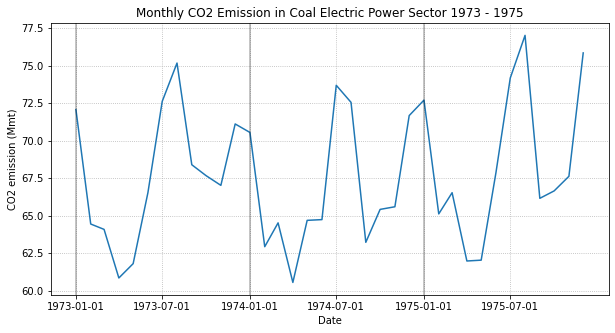

In [12]:
plt.figure(figsize=(10,5))
plt.plot(indexMonth['Value'].iloc[:36])
plt.xticks(indexMonth.index[:36:6])
for year in ('1973-01-01','1974-01-01','1975-01-01'):
    plt.axvline(pd.to_datetime(year),color='k',alpha=0.3)
plt.xlabel('Date')
plt.ylabel('CO2 emission (Mmt)')
plt.title('Monthly CO2 Emission in Coal Electric Power Sector 1973 - 1975')
plt.grid(True,linestyle=':')
plt.show()

The figure supports the existence of a strong seasonal component, resembling a W-shaped pattern, which approaches yearly minimum in April and yearly maximum in July or August.

#### Separate sectors

The month dataset is further divided according to 9 sectors.

In [ ]:
coal=indexMonth.loc[indexMonth['Column_Order']==1,'Value']
natural_gas=indexMonth.loc[indexMonth['Column_Order']==2,'Value']
distillate_fuel=indexMonth.loc[indexMonth['Column_Order']==3,'Value']
petroleum_coke=indexMonth.loc[indexMonth['Column_Order']==4,'Value']
residual_fuel_oil=indexMonth.loc[indexMonth['Column_Order']==5,'Value']
petroleum=indexMonth.loc[indexMonth['Column_Order']==6,'Value']
geothermal=indexMonth.loc[indexMonth['Column_Order']==7,'Value']
nonbiomass_waste=indexMonth.loc[indexMonth['Column_Order']==8,'Value']
total=indexMonth.loc[indexMonth['Column_Order']==9,'Value']

### Decomposition

Next, LOESS trend-season decomposition is conducted, which allows varying seasonality. The extraction of cycle is omitted since no cycle is observed in previous analysis. The decomposition results of Coal electric power sector is displayed below.

In [14]:
def decomposition(df):
    df_stl=stl(df).fit()
    season, trend, residual = df_stl.seasonal, df_stl.trend, df_stl.resid
    
    plt.figure(figsize=(10,12))

    plt.subplot(5,1,1)
    plt.plot(df)
    plt.title('Original CO2 Emission', fontsize=14)

    plt.subplot(5,1,2)
    plt.plot(trend)
    plt.title('CO2 Emission Trend Component', fontsize=14)

    plt.subplot(5,1,3)
    plt.plot(season)
    plt.title('CO2 Emission Seasonal Component', fontsize=14)

    plt.subplot(5,1,4)
    plt.plot(residual)
    plt.title('CO2 Emission Residual Component', fontsize=14)

    plt.subplot(5,1,5)
    plt.plot(df)
    plt.plot(season+trend,color='orange')
    plt.title('Trend and Seasonal Prediction', fontsize=14)
    
    plt.tight_layout()

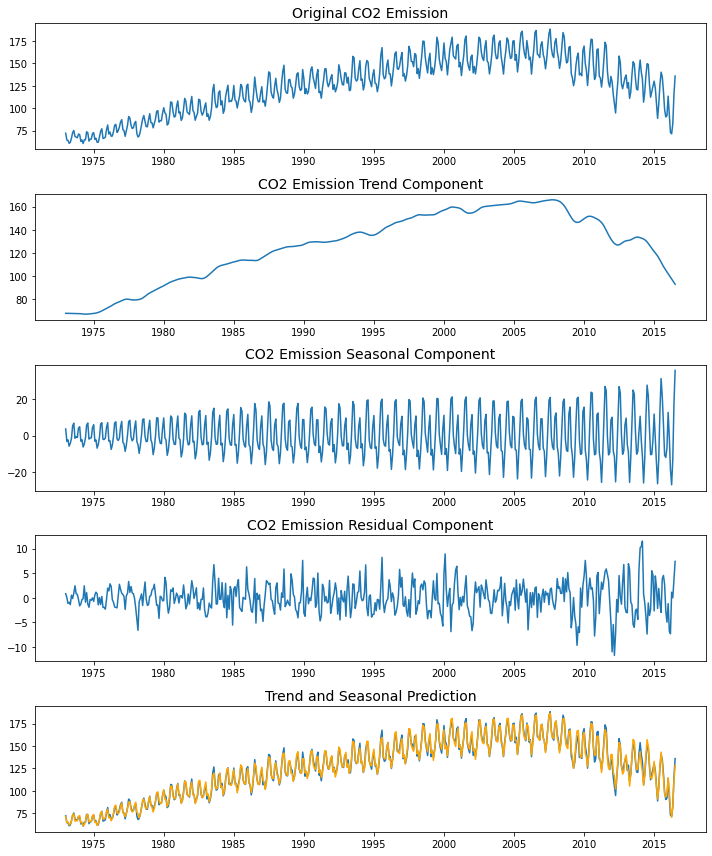

In [15]:
decomposition(coal)

The 5 figures in order are original data, trend, seasonality and residual, and the last one being original data plotted in blue compared with sum of trend and seasonality plotted in yellow. It demonstrates that trend and seasonality are able to predict the majority of the data. 

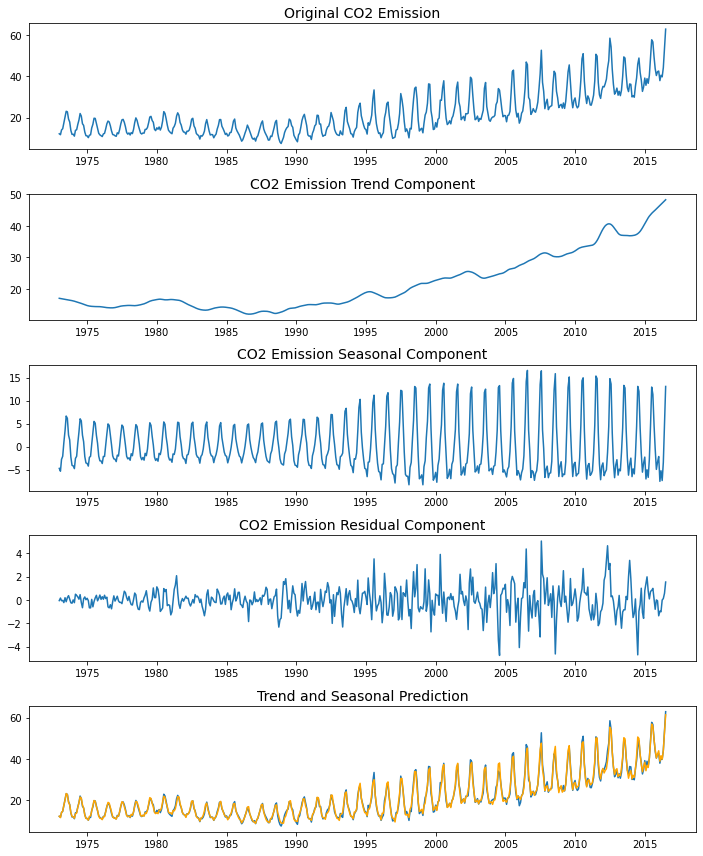

In [16]:
decomposition(natural_gas)

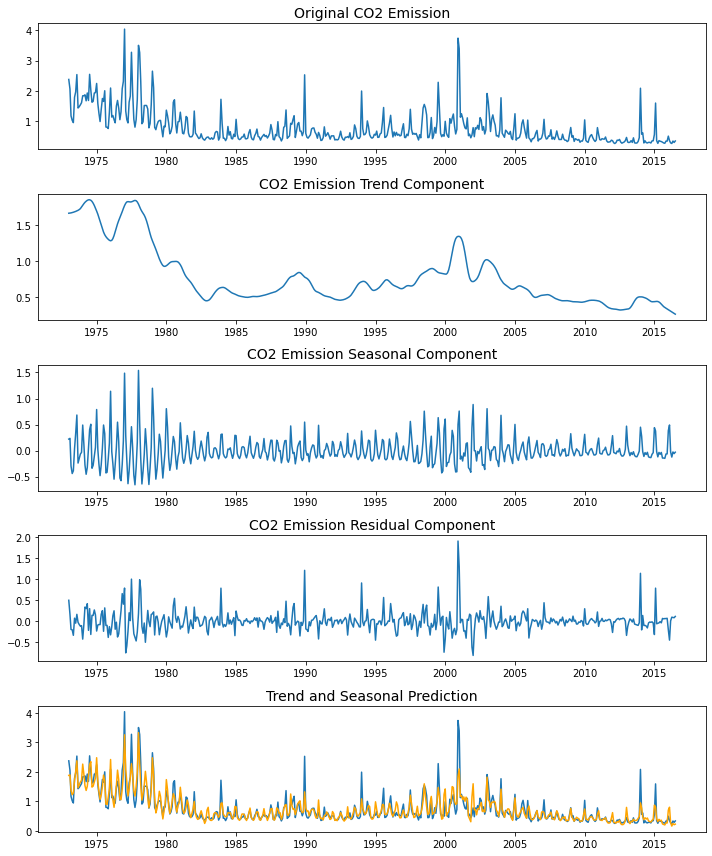

In [17]:
decomposition(distillate_fuel)

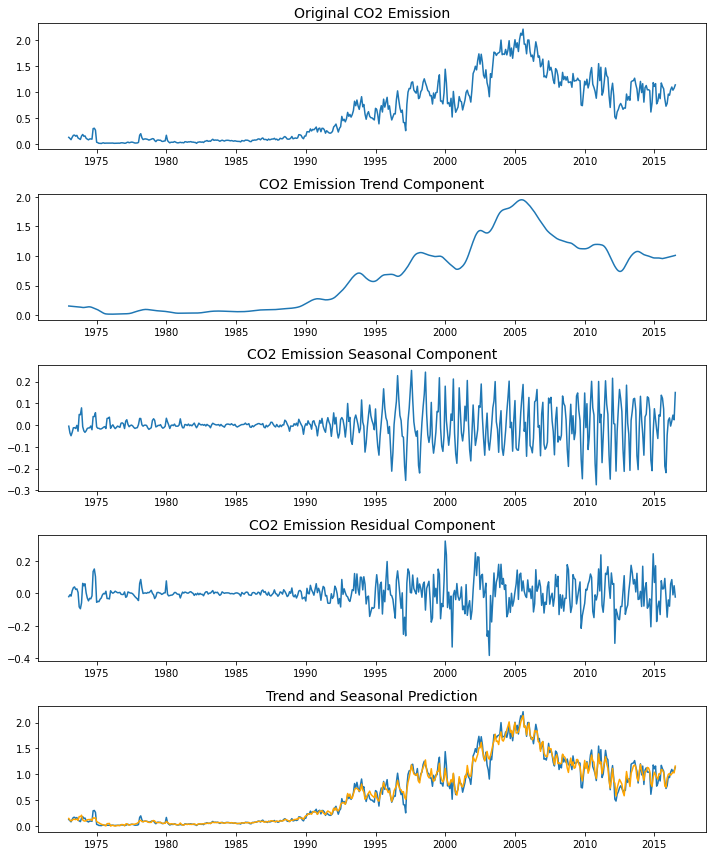

In [18]:
decomposition(petroleum_coke)

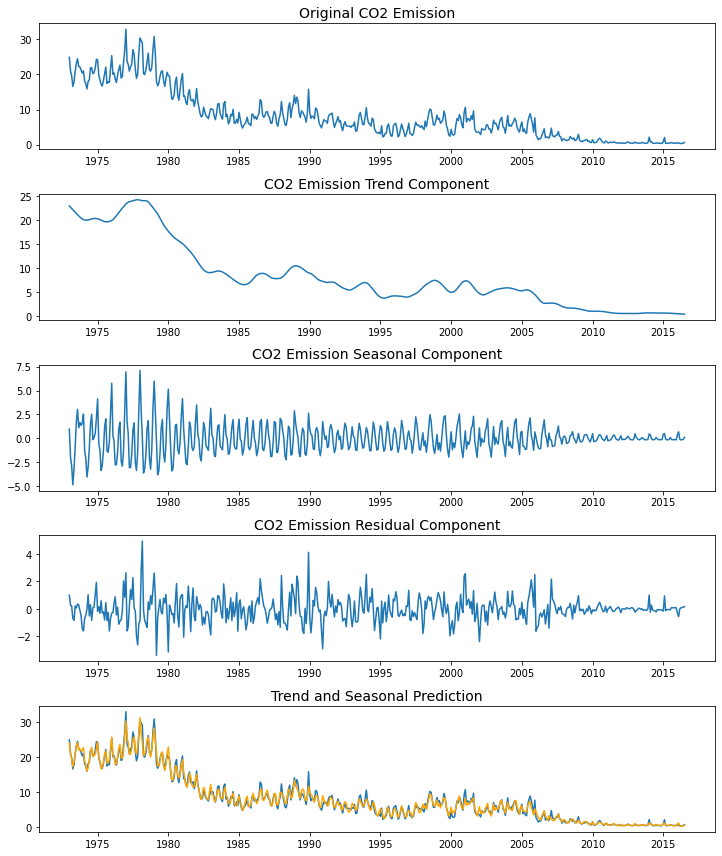

In [19]:
decomposition(residual_fuel_oil)

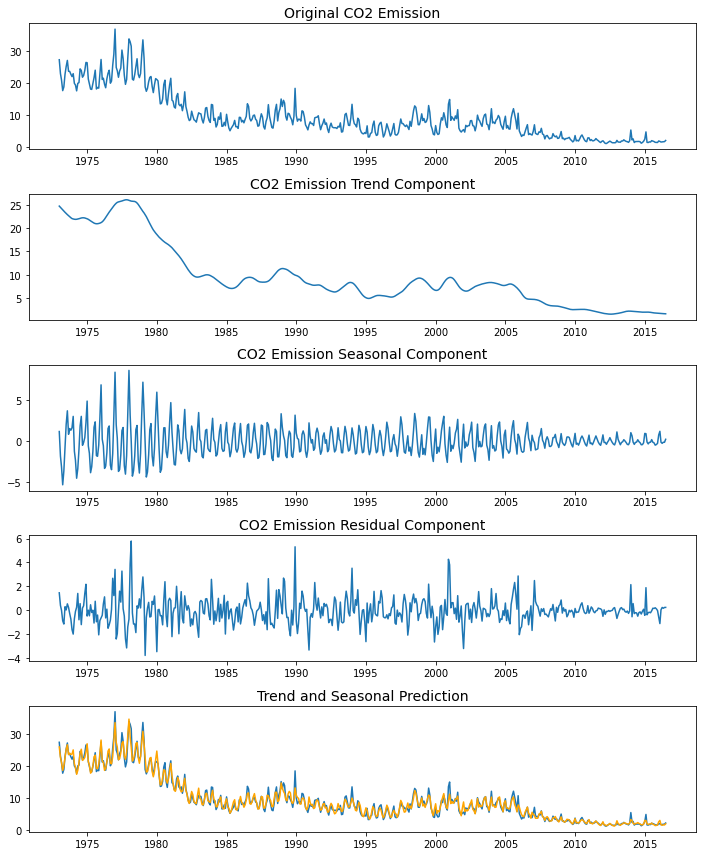

In [20]:
decomposition(petroleum)

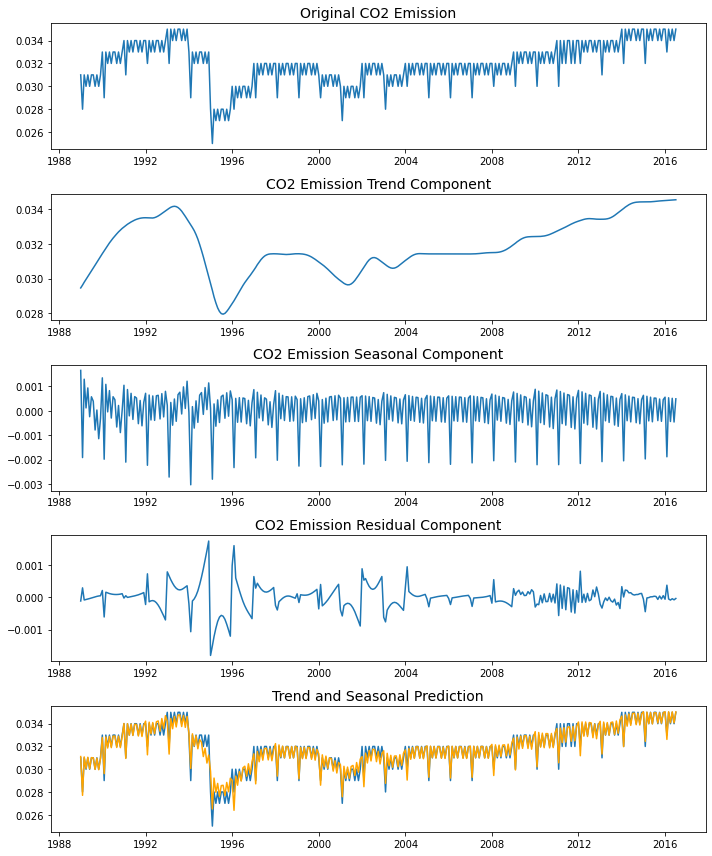

In [21]:
decomposition(geothermal)

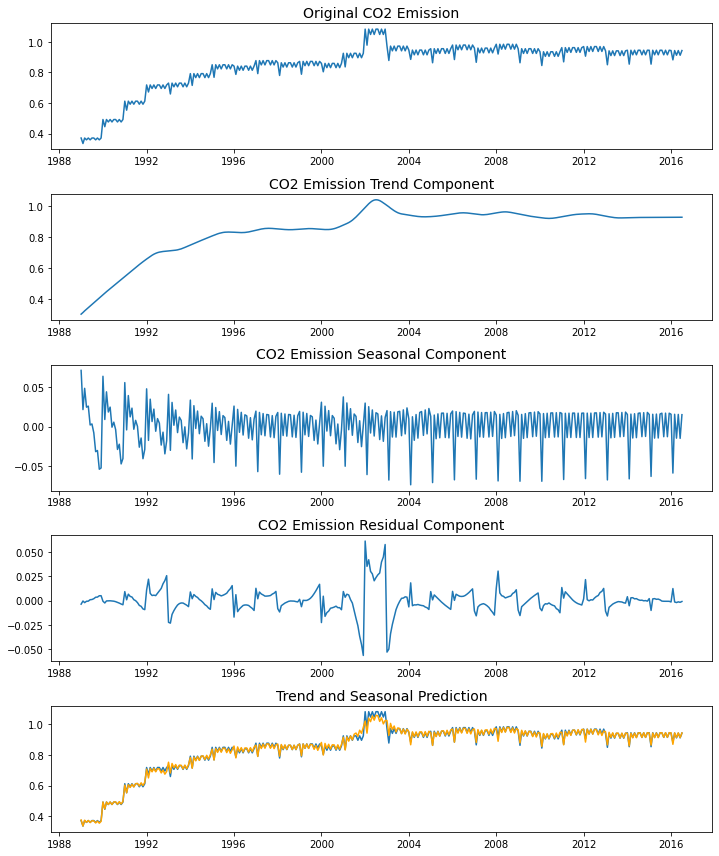

In [22]:
decomposition(nonbiomass_waste)

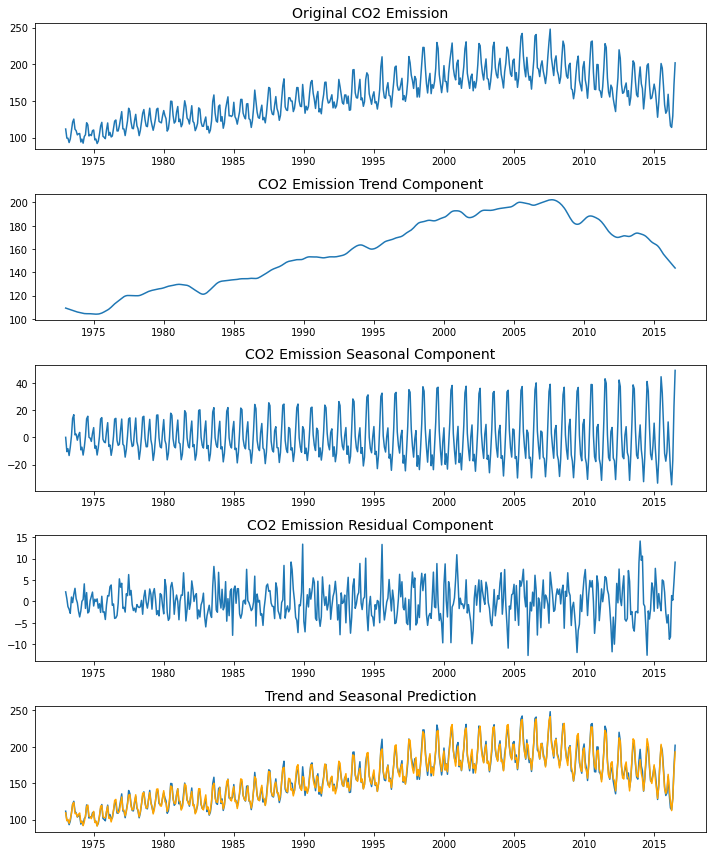

In [23]:
decomposition(total)

The same process is applied on the other 8 sectors. The rest of the sectors can also be mostly accounted for by trend and seasonality, including the total emission, except or Distillate Fuel and Petroleum Coke sectors with more residuals.

### Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)
#### Stationary

Based on above analysis, Seasonal Autoregressive Integrated Moving Average (SARIMA) model will be used for forecasting. ACF and PACF can be used to make estimation about model parameters and are better to be applied on stationary data. Based on the decomposed trend graph of Coal sector, it appears to be quadratic, therefore double differencing is applied. Furthermore, the mean is subtracted and annual standard deviation is divided to achieve zero mean and constant variance. The resulted stationary data is plotted.

In [24]:
def stationary(df):
    # remove quadratic trend, double differencing
    df=df.diff().dropna().diff().dropna()
    # normalisation, mean of zero
    df_mean= df.mean()
    # volacity
    # divide by annual std for constant variance and std of one
    df_std = df.groupby(df.index.year).std()
    df_annual_std=df.index.map(lambda d:df_std.loc[d.year])
    return (df-df_mean)/df_annual_std

In [25]:
coal_diff=stationary(coal_diff)

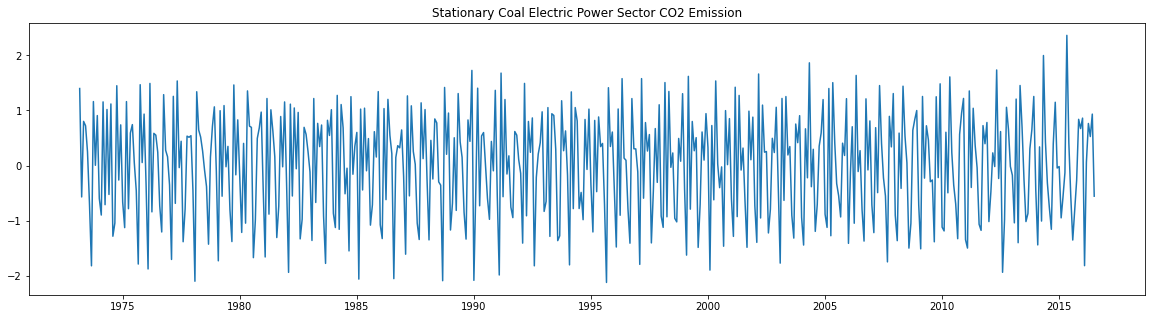

In [26]:
plt.figure(figsize=(20,5))
plt.plot(coal_diff)
plt.title('Stationary Coal Electric Power Sector CO2 Emission')
plt.show()

#### ACF

ACF and PACF are then applied on stationary Coal sector data and plotted.

In [27]:
def acf_plot(df):
    plot_acf(df)
    plt.xticks(np.arange(0,29,3))
    plt.grid(True)
    plt.show()

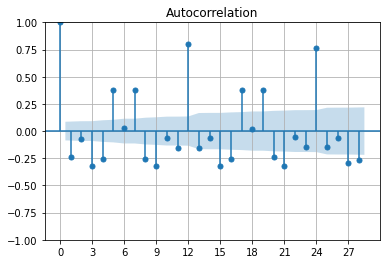

In [28]:
acf_plot(coal_diff)

#### PACF

In [29]:
def pacf_plot(df):
    plot_pacf(df)
    plt.xticks(np.arange(0,29,2))
    plt.grid(True)
    plt.show()

C:\Users\Chuyu\AppData\Roaming\Python\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


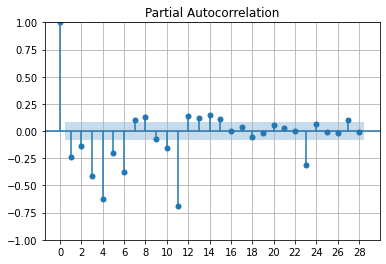

In [30]:
pacf_plot(coal_diff)

Both ACF and PACF figures show strong correlation at around 12 month. The spike at 12 month in ACF suggests MA and seasonal MA. The significant spike at 11 month in PACF suggests AR.

### Forecasting with SARIMA

Again, Coal electric sector is chosen for example because of its similarity with total emission. The Coal sector data from 1973 Jan to 2016 Jan is used for training. Based on ACF, PACF results and testing, SARIMA (1,1,1)(0,1,1,12) performs the best on Coal sector data according to AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) scores. The same model is then used to predict the first half of year 2016. The real data is drawn in blue and the forecasting is drawn in yellow for comparison.

#### Coal 2016 first half prediction

In [31]:
coal_train = coal[:datetime(2015,12,31)]
coal_test = coal[datetime(2016,1,1):]

coal_model = SARIMAX(coal_train,order=(1,1,1),seasonal_order=(0,1,1,12))
coal_sarima = coal_model.fit()
coal_sarima.summary()

C:\Users\Chuyu\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Chuyu\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Value   No. Observations:                  516
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1474.094
Date:                            Tue, 13 Jun 2023   AIC                           2956.188
Time:                                    21:37:51   BIC                           2973.071
Sample:                                01-01-1973   HQIC                          2962.811
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5910      0.056     10.500      0.000       0.481       0.701
ma.L1         -0.8603      0.037    -22.996      0.000      -0.934      -0.787
ma.S.L12      -0.7617      0.028    -27.217      0.000      -0.817      -0.707
sigma2        20.1137      1.072     18.769      0.000      18.013      22.214
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                27.22
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               2.62   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
coal_prediction=coal_sarima.forecast(6)
coal_residual = coal_test - coal_prediction

In [33]:
print(coal_prediction)

2016-01-01    103.425857
2016-02-01     92.426979
2016-03-01     88.700571
2016-04-01     73.489832
2016-05-01     87.134152
2016-06-01    106.423291
Freq: MS, Name: predicted_mean, dtype: float64


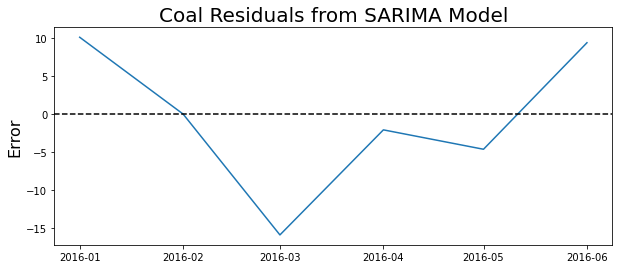

In [34]:
plt.figure(figsize=(10,4))
plt.plot(coal_residual)
plt.axhline(0, linestyle='--', color='k')
plt.title('Coal Residuals from SARIMA Model', fontsize=12)
plt.ylabel('Error', fontsize=16)
plt.show()

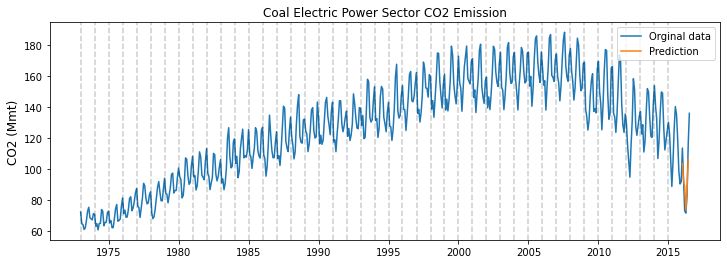

In [35]:
plt.figure(figsize=(12,4))
plt.plot(coal)
plt.plot(coal_prediction)
plt.legend(('Orginal data', 'Prediction'), fontsize=10)
plt.title('Coal Electric Power Sector CO2 Emission', fontsize=12)
plt.ylabel('CO2 (Mmt)', fontsize=12)
for year in range(datetime(1973,1,1).year,datetime(2016,7,1).year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

The model forecasting performance is satisfying.

#### Coal 1 year prediction

Next, all data is used for training and one-year forecasting after Jul 2016 (Jul 2016 - Jul 2017), which has higher AIC and BIC. Below is the model summary, predicted Coal sector emission and forecasting visualization.

In [36]:
coal_model = SARIMAX(coal,order=(1,1,1),seasonal_order=(0,1,1,12))
coal_sarima = coal_model.fit()
coal_sarima.summary()

C:\Users\Chuyu\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Chuyu\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Value   No. Observations:                  523
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1508.621
Date:                            Tue, 13 Jun 2023   AIC                           3025.242
Time:                                    21:37:51   BIC                           3042.180
Sample:                                01-01-1973   HQIC                          3031.883
                                     - 07-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6117      0.047     12.880      0.000       0.519       0.705
ma.L1         -0.8878      0.027    -33.065      0.000      -0.940      -0.835
ma.S.L12      -0.7542      0.028    -26.913      0.000      -0.809      -0.699
sigma2        21.2599      1.108     19.184      0.000      19.088      23.432
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                33.91
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               2.97   Skew:                            -0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
coal_prediction=coal_sarima.forecast(12)
print(coal_prediction)

2016-08-01    130.292531
2016-09-01    107.499109
2016-10-01     93.524524
2016-11-01     92.105924
2016-12-01    102.830491
2017-01-01    111.136157
2017-02-01     94.213198
2017-03-01     84.401615
2017-04-01     71.266792
2017-05-01     83.576274
2017-06-01    105.917423
2017-07-01    122.775194
Freq: MS, Name: predicted_mean, dtype: float64


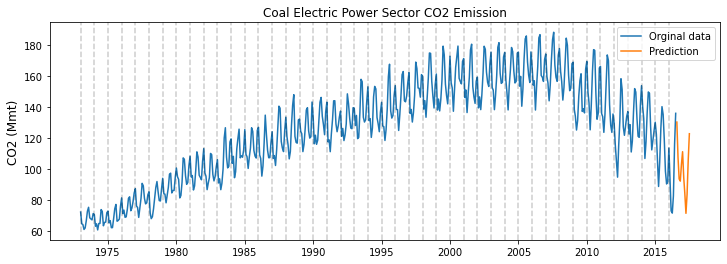

In [38]:
plt.figure(figsize=(12,4))
plt.plot(coal)
plt.plot(coal_prediction)
plt.legend(('Orginal data', 'Prediction'), fontsize=10)
plt.title('Coal Electric Power Sector CO2 Emission', fontsize=12)
plt.ylabel('CO2 (Mmt)', fontsize=12)
for year in range(datetime(1973,1,1).year,datetime(2017,1,1).year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

#### Total 1 year prediction

The same forecasting process is used for Total Energy electric power sector CO2 emission. The same model parameters (1,1,1)(0,1,1,12) are tested, and found to perform the best. One-year forecasting after 2016 Jul is conducted for Total emission as displayed below. 

In [39]:
total_model = SARIMAX(total,order=(1,1,1),seasonal_order=(0,1,1,12))
total_sarima = total_model.fit()
total_sarima.summary()

C:\Users\Chuyu\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Chuyu\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Value   No. Observations:                  523
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1653.144
Date:                            Tue, 13 Jun 2023   AIC                           3314.288
Time:                                    21:37:52   BIC                           3331.226
Sample:                                01-01-1973   HQIC                          3320.929
                                     - 07-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5172      0.048     10.870      0.000       0.424       0.610
ma.L1         -0.8999      0.025    -36.033      0.000      -0.949      -0.851
ma.S.L12      -0.7797      0.030    -25.979      0.000      -0.838      -0.721
sigma2        37.3612      2.015     18.542      0.000      33.412      41.310
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                10.96
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.58   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [40]:
total_prediction=total_sarima.forecast(12)
print(total_prediction)

2016-08-01    194.404114
2016-09-01    160.798984
2016-10-01    141.195650
2016-11-01    135.571968
2016-12-01    149.765541
2017-01-01    159.684828
2017-02-01    138.494682
2017-03-01    130.653694
2017-04-01    116.617399
2017-05-01    133.105359
2017-06-01    162.170495
2017-07-01    188.402628
Freq: MS, Name: predicted_mean, dtype: float64


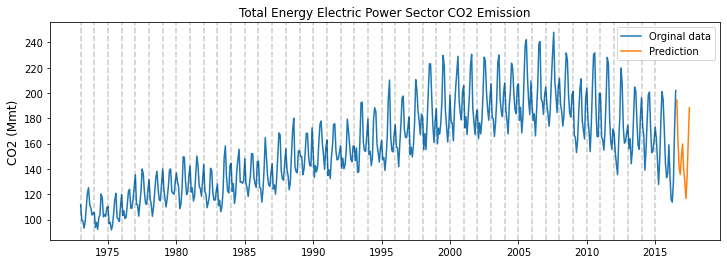

In [41]:
# plot prediction
plt.figure(figsize=(12,4))
plt.plot(total)
plt.plot(total_prediction)
plt.legend(('Orginal data', 'Prediction'), fontsize=10)
plt.title('Total Energy Electric Power Sector CO2 Emission', fontsize=12)
plt.ylabel('CO2 (Mmt)', fontsize=12)
for year in range(datetime(1973,1,1).year,datetime(2016,12,1).year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

Overall, the SARIMA models predict total CO2 emission from electric power to be in gradual decline, maintained below 200 Mmt, with maximum at 194 in August 2016 and minimum at 117 Mmt in April 2017, in accordance with previous observations.

## Dataset 2 – countries

Similarly to dataset one, dataset two is nonlinear and continuous. It contains 230 countries and the world CO2 emission values of each year from 1751 to 2017.
Data is preprocessed so that the data type is converted to numeric and date-time is the index. No null value exists.

In [42]:
from statsmodels.tsa.arima.model import ARIMA

### Preprocessing

In [44]:
# transpose
df2=df2.T
# set first row as column names
df2.columns = df2.iloc[0]
# remove first row
df2 = df2[1:]
# get df2 index as datetime type
df2_index=pd.to_datetime(df2.index,format='%Y')
# set the new index
df2=df2.set_index(df2_index)
# convert to numeric
df2 = df2.apply(pd.to_numeric)

In [45]:
# separate data
world=df2['World']
countries=df2.drop('World',axis=1)
# set frequency
world = world.asfreq(pd.infer_freq(world.index))

### Overview
#### Pie chart

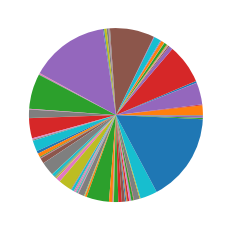

In [47]:
plt.pie(countries.iloc[-1,:])
plt.show()

Confirming the previous findings, the biggest purple and blue slides are European Union and United Kingdom.

#### Temporal graph
#### All countries and world

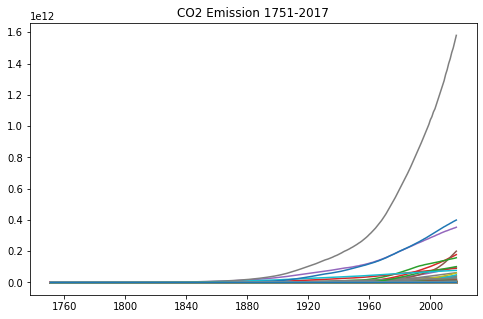

In [48]:
plt.figure(figsize=(8,5))
plt.plot(df2)
plt.title('CO2 Emission 1751-2017')
plt.show()

Above is the plot of CO2 emissions of all 230 countries from 1751 to 2017, the prominent gray line is the world total emission. It can be observed that most countries start CO2 emission after 1880. The only exception is the origin of Industrial Revolution - United Kingdom, who started emission since beginning of the data 1751. Although European Union also shows emission since 1751, it has the same numbers as UK, indicating UK was the sole contributor.

#### Only countries from 1880

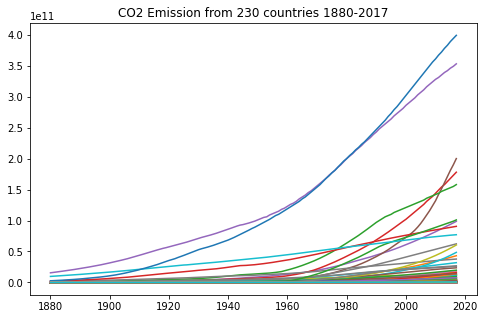

In [49]:
plt.figure(figsize=(8,5))
plt.plot(countries[datetime(1880,1,1):])
plt.title('CO2 Emission from 230 countries 1880-2017')
plt.show()

For more details, above is the plot of 230 countries’ emission from 1880 to 2017, without world total. All lines share similar trend and no visible cycles. Since no seasonal data is available, seasonality is not observable in this dataset. For their similarity and simplicity, the world total is chosen as the example for further analysis and forecasting.

### World emission

The world emission data is continuously used as an example in this section. As stated in dataset one analysis, stationarity needs to be achieved before applying ACF and PACF. The data is suspected to be exponential based on visualization. However, logarithm transformation on original data is not able to make it stationary. Instead, double differencing is able to achieve constant mean.  
ACF and PACF are then applied on the double differenced data.

#### Double differencing

In [50]:
world_diff=world.diff().dropna().diff().dropna()

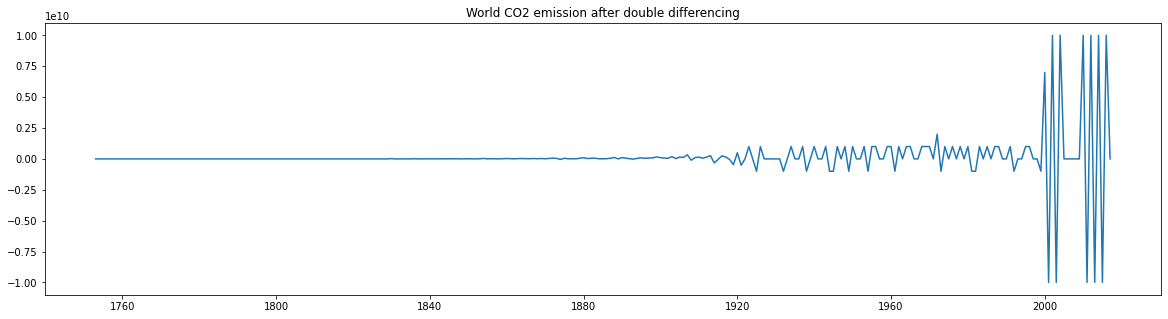

In [51]:
plt.figure(figsize=(20,5))
plt.plot(world_diff)
plt.title("World CO2 emission after double differencing")
plt.show()

#### decomposition

In [52]:
def decomposition2(df):
    df_stl=stl(df,period=12).fit()
    season, trend, residual = df_stl.seasonal, df_stl.trend, df_stl.resid
    
    plt.figure(figsize=(10,12))

    plt.subplot(5,1,1)
    plt.plot(df)
    plt.title('Original CO2 Emission', fontsize=14)

    plt.subplot(5,1,2)
    plt.plot(trend)
    plt.title('CO2 Emission Trend Component', fontsize=14)

    plt.subplot(5,1,3)
    plt.plot(season)
    plt.title('CO2 Emission Seasonal Component', fontsize=14)

    plt.subplot(5,1,4)
    plt.plot(residual)
    plt.title('CO2 Emission Residual Component', fontsize=14)

    plt.subplot(5,1,5)
    plt.plot(df)
    plt.plot(trend,color='orange')
    plt.title('Trend Prediction', fontsize=14)
    
    plt.tight_layout()

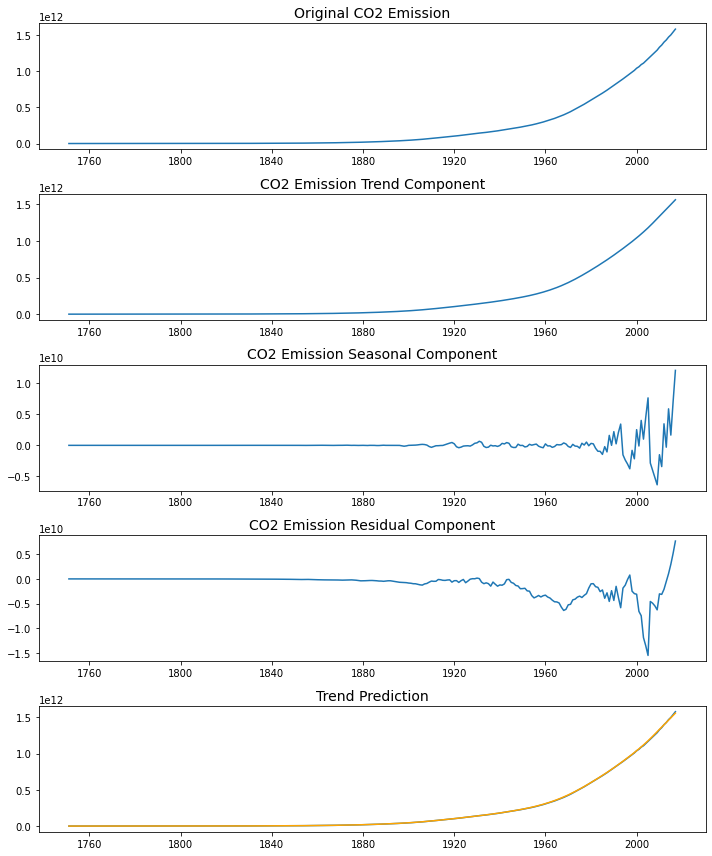

In [53]:
decomposition2(world)

#### ACF & PACF

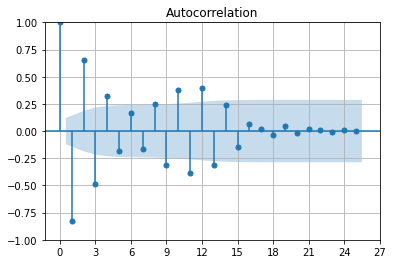

In [54]:
acf_plot(world_diff)

C:\Users\Chuyu\AppData\Roaming\Python\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


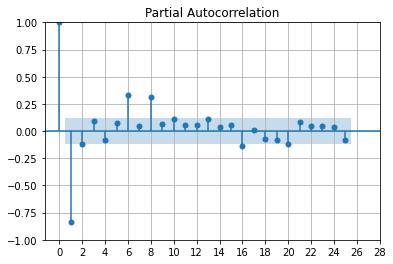

In [55]:
pacf_plot(world_diff)

The gradual decrease in ACF and significant drop after lag 1 in PACF suggests an AR order of 1 but no MA. Combined with the information about double differencing and no seasonality, an ARIMA model (1,2,0) should be used in forecasting.

### Forecasting with ARIMA

The world total emission is also used for forecasting. After testing, (1,2,0) is confirmed as the chosen ARIMA model parameters because of low AIC and BIC. An 11-year forecasting is conduced. The model summary, prediction numbers and figure are displayed below.

In [56]:
world_model = ARIMA(world,order=(1,2,0))
world_sarima = world_model.fit()
world_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  World   No. Observations:                  267
Model:                 ARIMA(1, 2, 0)   Log Likelihood               -5918.842
Date:                Wed, 14 Jun 2023   AIC                          11841.684
Time:                        01:58:50   BIC                          11848.844
Sample:                    01-01-1751   HQIC                         11844.561
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8214      0.011    -73.227      0.000      -0.843      -0.799
sigma2      1.477e+18   2.16e-21   6.83e+38      0.000    1.48e+18    1.48e+18
===================================================================================
Ljung-Box (L1) (Q):                   2.62   Jarque-Bera (JB):             13179.70
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):          231701.95   Skew:                             4.63
Prob(H) (two-sided):                  0.00   Kurtosis:                        36.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.23e+54. Standard errors may be unstable.
"""

In [57]:
world_prediction=world_sarima.forecast(11)
print(world_prediction)

2018-01-01    1.620000e+12
2019-01-01    1.660000e+12
2020-01-01    1.700000e+12
2021-01-01    1.740000e+12
2022-01-01    1.780000e+12
2023-01-01    1.820000e+12
2024-01-01    1.860000e+12
2025-01-01    1.900000e+12
2026-01-01    1.940000e+12
2027-01-01    1.980000e+12
2028-01-01    2.020000e+12
Freq: AS-JAN, Name: predicted_mean, dtype: float64


In [58]:
print('{:.0f}'.format(2.020000e+12))

2020000000000


Text(0, 0.5, 'CO2')

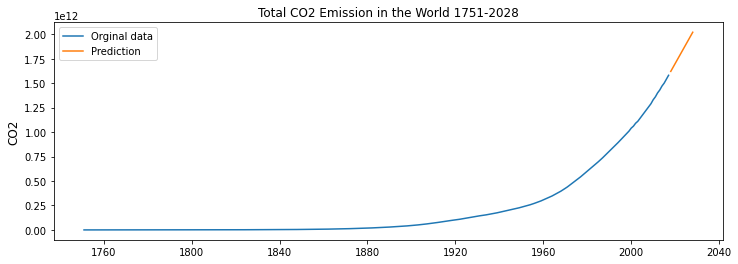

In [59]:
# plot prediction
plt.figure(figsize=(12,4))
plt.plot(world)
plt.plot(world_prediction)
plt.legend(('Orginal data', 'Prediction'), fontsize=10)
plt.title('Total CO2 Emission in the World 1751-2028', fontsize=12)
plt.ylabel('CO2', fontsize=12)
plt.show()

The ARIMA model predicts continuous growth in the future, achieving 2 trillion in 2028.

## Conclusion
Based on data one, the coal electric sector is responsible for most CO2 emissions from total electric power sectors from 1973 to 2016. All sectors show strong seasonality. Some sectors share strong resemblance with each other, such as residual fuel oil and petroleum electric power sectors. Based on data two, United Kingdom is the sole contributor to world CO2 emissions until around 1880. All countries exhibit similar increasing trend with no seasonality or cycles from 1751 to 2017.  
According to forecasting from SARIMA and ARIMA models, the CO2 emission from total electric power sector will be gradually decreasing in the future because of decrease in the most impactful sector - coal electric power. However, the total CO2 emission in the world is still rapidly increasing with no sign of mitigation.  
Overall, this report provides valuable insights into the CO2 emission patterns of electric power sectors and countries, emphasizing the need for continued efforts in mitigating and reducing CO2 emissions on a global scale.